# Policy Gradient Method

## Gym

In [1]:
import gymnasium as gym

print("\n".join(gym.envs.registry.keys()))

CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
phys2d/CartPole-v0
phys2d/CartPole-v1
phys2d/Pendulum-v0
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v2
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
tabular/Blackjack-v0
tabular/CliffWalking-v0
Reacher-v2
Reacher-v4
Pusher-v2
Pusher-v4
InvertedPendulum-v2
InvertedPendulum-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Walker2d-v2
Walker2d-v3
Walker2d-v4
Ant-v2
Ant-v3
Ant-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4
GymV21Environment-v0
GymV26Environment-v0


In [2]:
env = gym.make("CartPole-v1")
state = env.reset()
state, type(state)

((array([-0.02608106,  0.03936328, -0.02641061,  0.03470548], dtype=float32),
  {}),
 tuple)

In [3]:
action = env.action_space.sample()
action, env.action_space

(0, Discrete(2))

In [4]:
state, reward, done, trunc, info = env.step(action)
state, reward, done, trunc, info

(array([-0.02529379, -0.15537018, -0.0257165 ,  0.31893998], dtype=float32),
 1.0,
 False,
 False,
 {})

## REINFORCE

In [2]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RecordVideo  # pip install moviepy
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange

writer = SummaryWriter("logs")

plt.rcParams["figure.figsize"] = (14, 6)

In [18]:
def make_model():
    model = torch.nn.Sequential(
        torch.nn.Linear(4, 64),
        torch.nn.LeakyReLU(),
        # There is only two output action, 0 or 1
        torch.nn.Linear(64, 2),
        torch.nn.Softmax(),
    )
    return model

In [19]:
model = make_model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [20]:
def discount_rewards(rewards, gamma=0.99):
    returns = torch.pow(gamma, torch.arange(len(rewards))) * rewards
    return returns / returns.max()

In [21]:
discount_rewards(torch.Tensor([1, 2, 3, 4, 5]))

tensor([0.2082, 0.4122, 0.6122, 0.8081, 1.0000])

In [22]:
discount_rewards(torch.Tensor([1, 2, 3, 4, 5]).flip(dims=(0,)))

tensor([1.0000, 0.7920, 0.5881, 0.3881, 0.1921])

In [23]:
discount_rewards(torch.Tensor([1, 1, 1, 1, 1]))

tensor([1.0000, 0.9900, 0.9801, 0.9703, 0.9606])

In [24]:
def reinforce(model, optimzer, max_episodes=1000, max_trajectory=500, gamma=0.99):
    writer.add_hparams(
        dict(max_episodes=max_episodes, max_trajectory=max_trajectory, gamma=gamma),
        dict(),
        run_name="reinforce",
    )

    env = gym.make("CartPole-v1")
    scores = []
    for episode in trange(max_episodes):
        observation, _info = env.reset()
        transitions = []

        for t in range(max_trajectory):
            state = torch.from_numpy(observation)
            action_probs = model(state)
            action = torch.multinomial(action_probs, 1)
            observation, reward, done, trunc, _info = env.step(action.item())
            transitions.append((state, action, reward + t))
            if done or trunc:
                break
        scores.append(len(transitions))

        state_batch, action_batch, reward_batch = list(zip(*transitions))
        state_batch = torch.stack(state_batch)
        action_batch = torch.stack(action_batch)
        reward_batch = torch.Tensor(reward_batch).flip(dims=(0,))

        pred_batch = model(state_batch)
        prob_batch = pred_batch.gather(dim=1, index=action_batch).squeeze()
        disc_batch = discount_rewards(reward_batch)

        loss = -torch.sum(disc_batch * torch.log(prob_batch))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        writer.add_scalar("reinforce/episodes", len(transitions), episode)
        writer.add_scalar("reinforce/loss", loss.item(), episode)
    return scores

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'Episode duration')

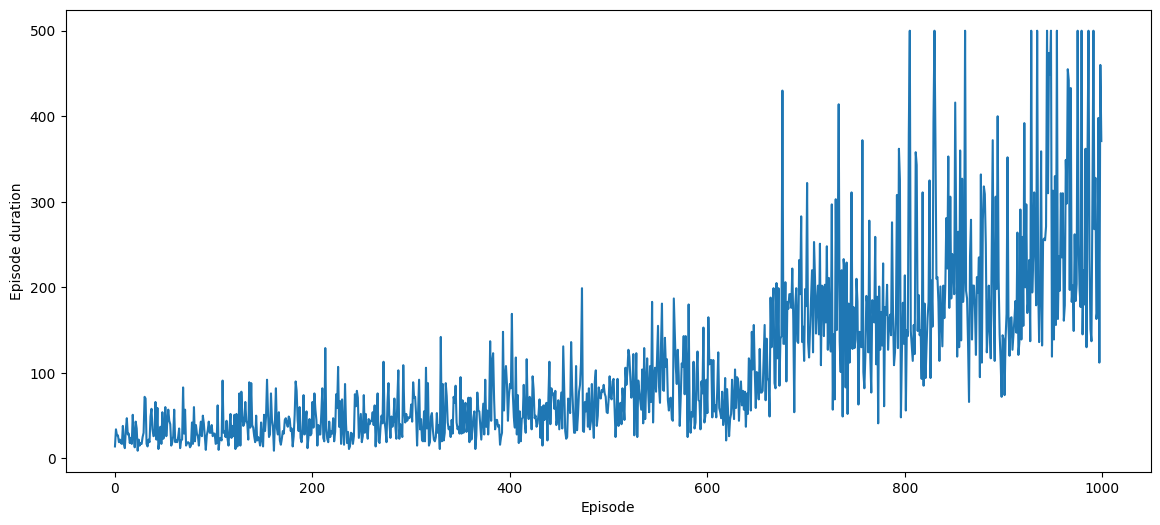

In [25]:
scores = reinforce(model, optimizer)
fig, ax = plt.subplots()
ax.plot(np.arange(len(scores)), scores)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode duration")

In [26]:
def test_reinforce(model, max_episodes=1000, max_trajectory=500):
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    if max_episodes == 1:
        env = RecordVideo(
            env,
            video_folder="./videos/",
            episode_trigger=lambda t: t % 10 == 0,
            disable_logger=True,
        )

    scores = []
    for episode in trange(max_episodes):
        observation, _info = env.reset()
        transitions = []

        for t in range(max_trajectory):
            state = torch.from_numpy(observation)
            with torch.no_grad():
                action_probs = model(state)
            action = torch.multinomial(action_probs, 1)
            observation, reward, done, trunc, _info = env.step(action.item())
            transitions.append((state, action, t + 1))
            if done or trunc:
                break
        scores.append(len(transitions))
    return scores

  0%|          | 0/1000 [00:00<?, ?it/s]

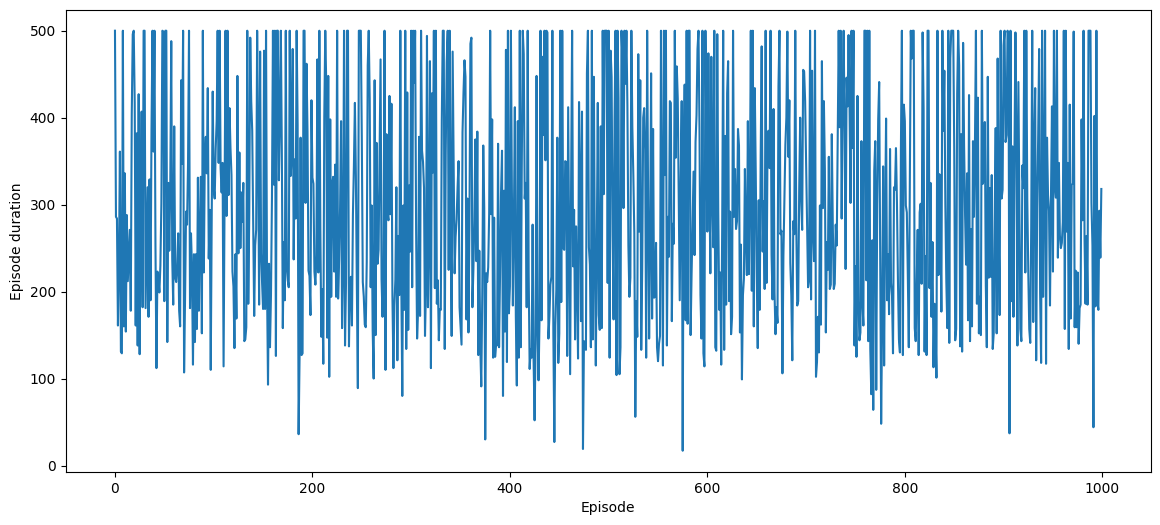

In [27]:
scores = test_reinforce(model, max_episodes=1000)

fig, ax = plt.subplots()
ax.plot(np.arange(len(scores)), scores)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode duration");

In [28]:
np.mean(scores), np.min(scores), np.max(scores)

(298.335, 17, 500)

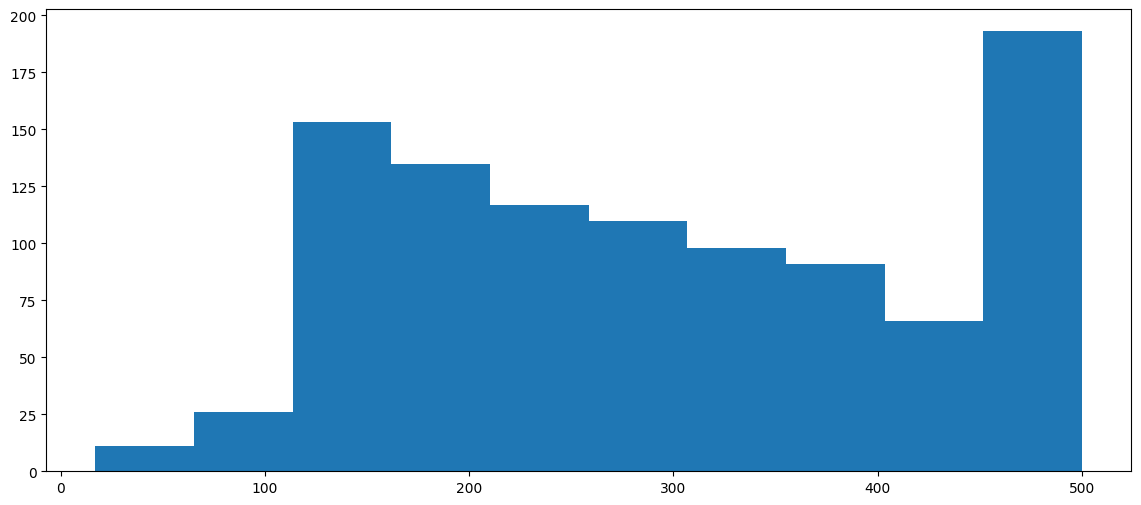

In [29]:
plt.hist(scores);

In [35]:
writer.add_histogram("reinforce/hist", np.array(scores), bins=50)